# Visualizing a 3D Surface with CVPy

This notebook demonstrates how to use CVPy to assist with visualization within an end-to-end biomedical image pipeline.
In this demo, an image is loaded from the Lung CT Segmentation Challenge 2017 data set. The DICOM-RT contours are loaded for that same image and used to create a 3D segmentation mask. A surface is built using the segmentation mask and displayed using CVPy.

Data source: https://wiki.cancerimagingarchive.net/display/Public/Lung+CT+Segmentation+Challenge+2017

### Import python libraries

In [1]:
from swat import *
from mayavi import mlab

### Import CVPy

In [2]:
from cvpy.visualization import *

### Connect to server

In [3]:
s = CAS("your-host-name.unx.com", 5570)

s.loadactionset("image")
s.loadactionset("biomedimage")
s.loadactionset("fedsql")

s.addcaslib(
    name="dlib",
    activeonadd=True,
    path="path/to/caslib",
    datasource="path",
    subdirectories=True,
)

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: Added action set 'fedsql'.
NOTE: 'dlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'dlib'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dlib,PATH,,/net/narndnas02.unx.sas.com/vol/vol2/fvcc/BMID...,,1.0,1.0,1.0,0.0,0.0,0.0


### Load slides

In [4]:
slides_dir = "CVPY_demo/CVPy_roi2mask_demo"
caslib_name = "casuser"


def load_slides(cas_session, slides_table):
    """Load the slides."""
    casout = s.CASTable(slides_table, replace=True)
    s.image.loadimages(path=slides_dir,
                       caslib="casuser",
                       casout=casout,
                       decode=True)
    fetched_slides = casout[["_resolution_", "_image_", "_path_"]].to_frame()
    slide_binaries = fetched_slides["_image_"]
    slide_resolutions = fetched_slides["_resolution_"]
    slide_paths = fetched_slides["_path_"]
    res = np.frombuffer(slide_resolutions[0], np.int64)
    slide_width = res[0]
    slide_height = res[1]
    return slide_binaries, slide_paths, slide_width, slide_height


slide_binaries, slide_paths, slide_width, slide_height = load_slides(s, "slides")

NOTE: Loaded 5 images from /u/coambr/CVPY_demo/CVPy_roi2mask_demo into Cloud Analytic Services table slides.


### Load the image

In [5]:
image = s.CASTable("image", replace=True)
s.image.loadimages(
    path="LCTSC/LCTSC-Test-S1-101",
    caslib="dlib",
    casout=image,
    addcolumns=dict(general=["position",
                             "orientation",
                             "spacing",
                             "channeltype",
                             "width",
                             "height",
                             "depth"],
                    dicomattributes=dict(keywords=["SeriesInstanceUID"])),
    series=dict(dicom=True),
    recurse=True,
    labellevels=1,
    decode=True
)

NOTE: Loaded 1 image from /net/narndnas02.unx.sas.com/vol/vol2/fvcc/BMIData/LCTSC/LCTSC-Test-S1-101 into Cloud Analytic Services table image.


,casLib,Name,Rows,Columns,casTable
0,dlib,image,1,17,"CASTable('image', caslib='dlib')"


NOTE: The table SLIDES contains decoded images.


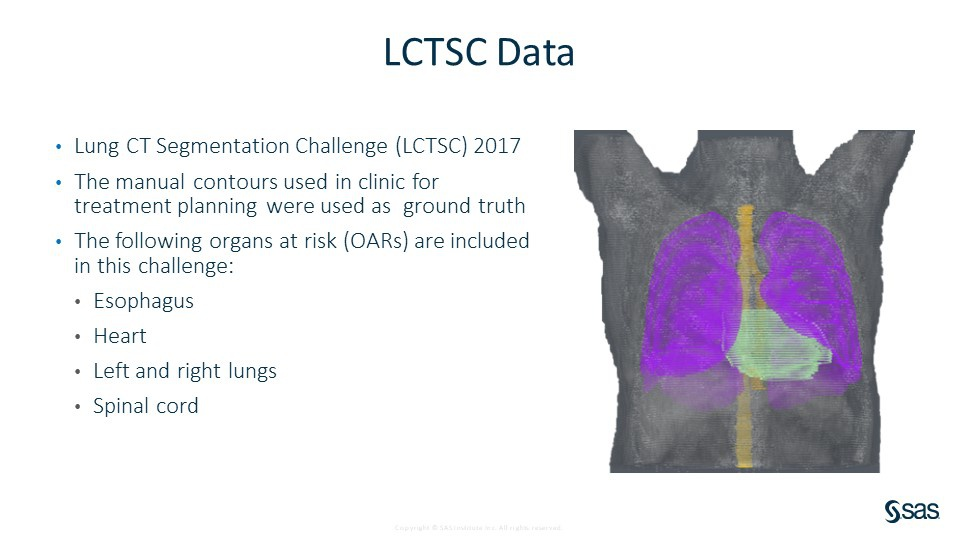

In [6]:
s.image.fetchImages(imagetable="slides").Images.Image[0]

Citation:

Yang, J., Sharp, G., Veeraraghavan, H., van Elmpt, W., Dekker, A., Lustberg, T., and Gooding, M. (2017). Data from Lung CT Segmentation Challenge. The Cancer Imaging Archive. DOI: 10.7937/K9/TCIA.2017.3r3fvz08.

Yang, J., Veeraraghavan, H., Armato, S. G., III, Farahani, K., Kirby, J. S., Kalpathy-Kramer, J., van Elmpt, W., Dekker, A., Han, X., Feng, X., Aljabar, P., Oliveira, B., van der Heyden, B., Zamdborg, L., Lam, D., Gooding, M., and Sharp, G. C. (2018). “Autosegmentation for Thoracic Radiation Treatment Planning: A Grand Challenge at AAPM 2017.” Medical Physics 45:4568−4581. DOI: 10.1002/mp.13141.

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., and Prior, F. (2013). “The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository.” Journal of Digital Imaging 26:1045−1057. DOI: 10.1007/s10278-013-9622-7.

### Load DICOM-RT data

In [7]:
rtcsq = "ROIContourSequence"
rtsuid = "ReferencedFrameOfReferenceSequence{1}RTReferencedStudySequence{1}RTReferencedSeriesSequence{1}SeriesInstanceUID"
allKeysRt = [rtsuid, rtcsq]

roi1color = "3006_0039_4_3006_002a"
organ = "3006_0020_4_3006_0026"
allTags = [roi1color, organ]

rtdata_points = s.CASTable("rtdata_points", replace=True)
s.biomedimage.loaddicomdata(
    path="LCTSC/LCTSC-Test-S1-101",
    caslib="dlib",
    casout=rtdata_points,
    addcolumns=dict(tags=allTags,
                    keywords=allKeysRt)
)

s.table.altertable(
    table="rtdata_points",
    columns=[dict(name="_" + roi1color + "_",
                  rename="color"),
             dict(name="_" + organ + "_",
                  rename="organ")]
)

imrt = s.CASTable("imrt", replace=True)
s.fedsql.execdirect(
    """create table imrt {options replace=true} as (select a._ROIContourSequence_, a.color, a.organ, b.*
    as rtid from rtdata_points as a inner join image as b on
    b._SeriesInstanceUID_=a._ReferencedFrameOfReferenceSequence_1_RTReferencedStudySequence_1_RTReferencedSeriesSequence_1_SeriesInstanceUID_
    WHERE a.organ='Heart')"""
)

NOTE: Loaded 131 DICOM data row(s) from path LCTSC/LCTSC-Test-S1-101 into table rtdata_points.
NOTE: Table IMRT was created in caslib dlib with 1 rows returned.


+ Elapsed: 14.5s, user: 13.6s, sys: 4.96s, mem: 5.06e+03mb

NOTE: The table SLIDES contains decoded images.


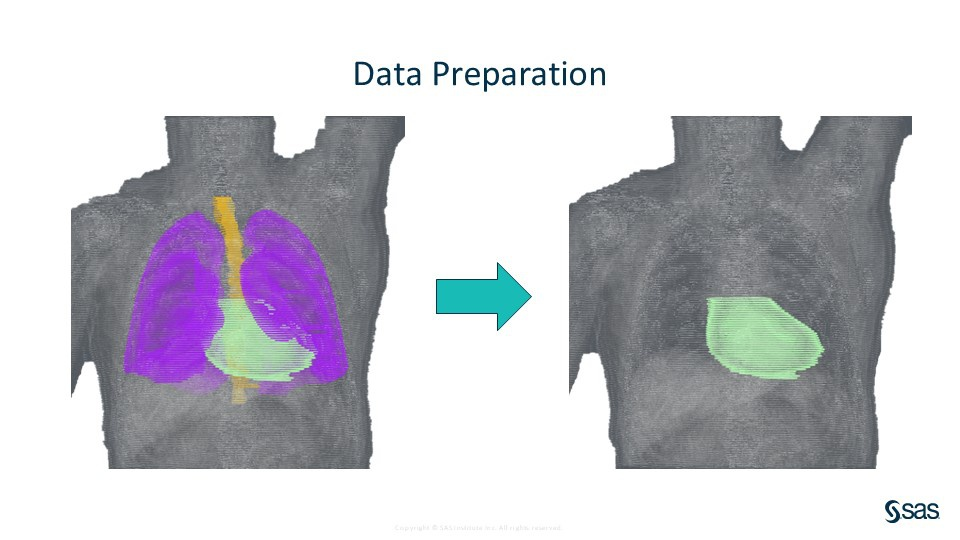

In [8]:
s.image.fetchImages(imagetable="slides").Images.Image[1]

### Use roi2mask to create a segmentation image

In [9]:
pdata = s.CASTable("pdata", replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=imrt),
    steps=[dict(stepparameters=dict(steptype="roi2mask",
                                    roi2maskparameters=dict(roi2masktype="dicomrt_specific",
                                                            roicontoursequence="_ROIContourSequence_",
                                                            correctionsensitivity=0.25,
                                                            pixelintensity=255,
                                                            outputbackground=0,
                                                            roidisplaycolor="179\\255\\178"))),
           dict(stepParameters=dict(steptype="rescale",
                                    rescaleparameters=dict(rescaleType="channeltype_8u")))],
    addcolumns=["width",
                "height",
                "depth",
                "channeltype",
                "position",
                "orientation",
                "spacing"],
    decode=True,
    casout=dict(name="seg_img",
                replace=True),
    copyvars=["_id_",
              "_label_"]
)

NOTE: Processed 1 image from Cloud Analytic Services table IMRT.


,casLib,Name,Rows,Columns,casTable
0,dlib,seg_img,1,14,"CASTable('seg_img', caslib='dlib')"


### Build the surface of the heart

In [10]:
image_rows = s.CASTable("imrt").to_frame()

dim = image_rows["_dimension_"]
fmt = image_rows["_channelType_"]
images = image_rows["_image_"]
res = image_rows["_resolution_"]
sca = image_rows["_spacing_"]
pos = image_rows["_position_"]
ori = image_rows["_orientation_"]
id = image_rows["_id_"]

s.table.altertable(
    table="seg_img",
    columns=[dict(name="_dimension_",
                  rename="dim"),
             dict(name="_resolution_",
                  rename="res"),
             dict(name="_imageformat_",
                  rename="form"),
             dict(name="_orientation_",
                  rename="ori"),
             dict(name="_position_",
                  rename="pos"),
             dict(name="_spacing_",
                  rename="spa")]
)

joined = s.CASTable("joined")
s.fedsql.execdirect(
    "create table joined {options replace=true} as "
    "select a.*, b._position_, b._orientation_, b._spacing_ "
    "from seg_img as a inner join imrt as b "
    "on a._id_=b._id_"
)

verticesMasked = s.CASTable("verticesMasked", replace=True)
facesMasked = s.CASTable("facesMasked", replace=True)

resultTab = s.biomedimage.buildsurface(
    images=dict(table=joined,
                dimension="dim",
                resolution="res",
                imageformat="form"),
    thresholds=[dict(low=254,
                     high=255)],
    smoothing=dict(iterations=3),
    outputvertices=verticesMasked,
    outputfaces=facesMasked
)

NOTE: Table JOINED was created in caslib dlib with 1 rows returned.
NOTE: Processed 1 image from Cloud Analytic Services table JOINED.


### Display the built surface
This cell contains two CVPy functions, display_3D_surface and display_image_slice. The function display_3D_surface displays the surface that was built by the buildsurface action, specifying the the color and the opacity of the surface. The function display_image_slice displays a stagnant slice on a particular axis of the 3D image.

In [11]:
display_3D_surface(resultTab.Surfaces, verticesMasked, facesMasked, True, color=(1, 0, 0), op=0.9)
display_image_slice(images, dim, res, fmt, pos, ori, sca, (0, 1, 2), 0, 10, 0)
display_image_slice(images, dim, res, fmt, pos, ori, sca, (2, 1, 0), 0, 150, 0)
display_image_slice(images, dim, res, fmt, pos, ori, sca, (1, 0, 2), 0, 300, 0)
mlab.show()

NOTE: The table SLIDES contains decoded images.


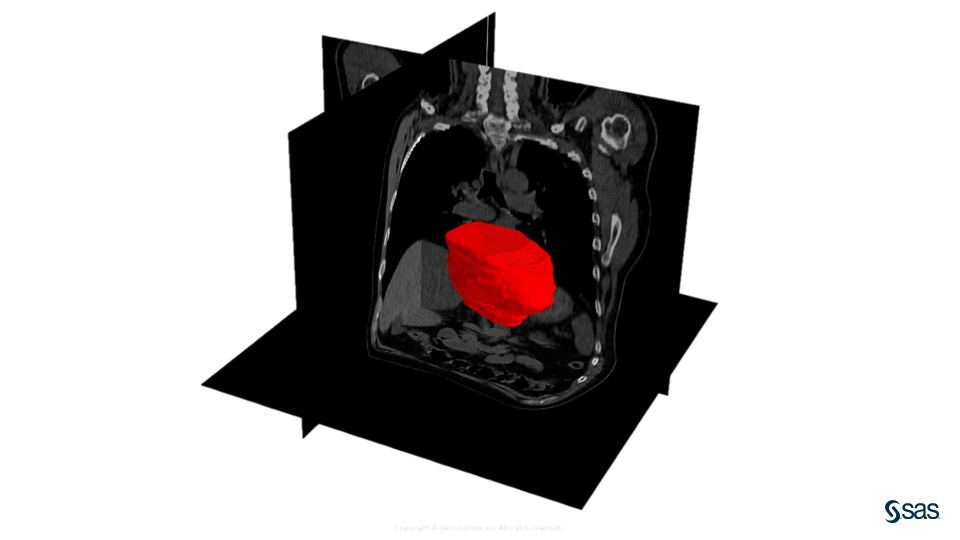

In [12]:
s.image.fetchImages(imageTable="slides").Images.Image[2]

In [13]:
s.table.altertable(
    table="seg_img",
    columns=[dict(name="_image_",
                  rename="seg")]
)

to_mask = s.CASTable("to_mask", replace=True)
s.fedsql.execdirect(
    "create table to_mask {options replace=true} as "
    "select a.*, b._image_, b._orientation_, b._spacing_, b._dimension_, b._imageFormat_, b._resolution_ "
    "from seg_img as a inner join image as b "
    "on a._id_=b._id_"
)

NOTE: Table TO_MASK was created in caslib dlib with 1 rows returned.


+ Elapsed: 19.4s, user: 19.6s, sys: 6.46s, mem: 5.4e+03mb

### Use segmentation to mask the original image

In [14]:
masked_img = s.CASTable("masked_img", replace=True)

s.biomedimage.processbiomedimages(
    images=dict(table=to_mask),
    steps=[dict(stepparameters=dict(steptype="binary_operation",
                                    binaryoperation=dict(binaryoperationtype="mask_specific",
                                                         image="seg",
                                                         dimension="dim",
                                                         resolution="res",
                                                         imageformat="form",
                                                         outputBackground=-1000)))],
    casout=masked_img,
    decode=True,
    addcolumns=["width",
                "height",
                "depth",
                "channeltype",
                "position",
                "orientation",
                "spacing"],
    copyvars=["_label_",
              "_id_"]
)

NOTE: Processed 1 image from Cloud Analytic Services table TO_MASK.


,casLib,Name,Rows,Columns,casTable
0,dlib,masked_img,1,14,"CASTable('masked_img', caslib='dlib')"


In [15]:
display_3D_image_slices(s, "masked_img")

NOTE: The table SLIDES contains decoded images.


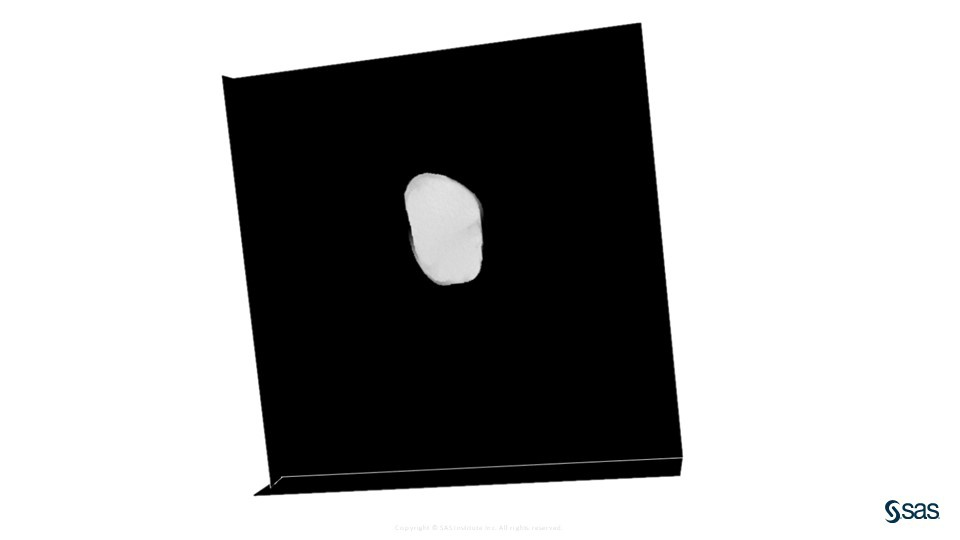

In [16]:
s.image.fetchImages(imagetable="slides").Images.Image[3]

### Quantify metrics of the image

In [17]:
quantities = s.CASTable(name="quantities", replace=True)

s.biomedimage.quantifyBioMedImages(
    images=dict(table="masked_img"),
    region="component",
    quantities=[dict(quantityparameters=dict(quantitytype="mean")),
                dict(quantityparameters=dict(quantitytype="minimum")),
                dict(quantityparameters=dict(quantitytype="maximum")),
                dict(quantityparameters=dict(quantitytype="std")),
                dict(quantityparameters=dict(quantitytype="content",
                                             usespacing=True))],
    inputbackground=-1000,
    labelparameters=dict(labelType="basic",
                         connectivity="vertex"),
    casout=quantities
)

NOTE: Processed 1 image from Cloud Analytic Services table MASKED_IMG.


,casLib,Name,Rows,Columns,casTable
0,dlib,quantities,1,7,"CASTable('quantities', caslib='dlib')"


### Display quantified metrics

In [18]:
quantities.to_frame()

,_imageId_,_componentLabel_,_mean_,_minimum_,_maximum_,_std_,_content_
0,1,1.0,34.457125,-507.0,243.0,41.458783,746797.750598
